# Load mutual fund return data from csv

In [1]:
# Import all the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import FuncFormatter
import sklearn.linear_model as lm
import statsmodels.api as sm
from tqdm.notebook import trange, tqdm
from sklearn.linear_model import LinearRegression
from numpy.linalg import inv
from numpy.linalg import inv
from scipy.stats import f

In [2]:
# Read data into dataframe
## Read the data with the 500 funds through time with only funds that contain management fees and turnover data
data = pd.read_csv('fund_data_largest_500_with_fees.csv')

# Convert the 'caldt' to a Python datetime and then to the Fama-French date format (YYYYMM)
data['Date'] = pd.to_datetime(data['caldt'], format="%Y%m%d")
data['YYYYMM'] = data['Date'].dt.strftime('%Y%m').astype(int)

# Set multi-column index (YYYYMM and crsp_fundno), but keep original columns
data.set_index(['YYYYMM','crsp_fundno'], drop=False, inplace=True)

# Print the top 3 rows
# print(data.head(3))
# print(data.columns)
# data.head(10).to_excel('Quick sample for inspection.xlsx')

# Load the Fama-French series

In [3]:
#  Load the 5 Factor into dataframe
famafrench = pd.read_csv('F-F_Research_Data_5_Factors_2x3.CSV', index_col=0, skiprows=3)

#  Load the 5 Factor into dataframe
momentum = pd.read_csv('F-F_Momentum_Factor.CSV', skiprows=13, index_col=0)

# Left-join the momentum dataframe to the famafrench dataframe
famafrench = famafrench.merge(momentum, left_index=True, right_index=True, how='left')

# Only select CAPM, Fama-French 3 models and 4-factors Carhart model
#famafrench = famafrench[['Mkt-RF', 'SMB', 'HML', 'RF', 'Mom']]

# Rename the momentum column to "WML"
famafrench.rename(columns={"Mom":"WML"}, inplace=True)

# Make returns into decimals instead of percentages
famafrench = famafrench / 100
display(famafrench)

,Mkt-RF,SMB,HML,RMW,CMA,RF,WML
196307,-0.0039,-0.0045,-0.0094,0.0066,-0.0115,0.0027,0.0100
196308,0.0507,-0.0082,0.0182,0.0040,-0.0040,0.0025,0.0103
196309,-0.0157,-0.0048,0.0017,-0.0076,0.0024,0.0027,0.0016
196310,0.0253,-0.0130,-0.0004,0.0275,-0.0224,0.0029,0.0314
196311,-0.0085,-0.0085,0.0170,-0.0045,0.0222,0.0027,-0.0075
...,...,...,...,...,...,...,...
202008,0.0763,-0.0094,-0.0294,0.0427,-0.0144,0.0001,0.0051
202009,-0.0363,0.0007,-0.0251,-0.0115,-0.0177,0.0001,0.0305
202010,-0.0210,0.0476,0.0403,-0.0060,-0.0053,0.0001,-0.0303
202011,0.1247,0.0675,0.0211,-0.0278,0.0105,0.0001,-0.1225


### Fama-French cumulative return plot (after 2000)

In [4]:
# Get sample period
famafrench_sample = famafrench[famafrench.index > 199912]

# Calculate cumulative returns on the dataframe
#famafrench_cumprod = np.cumprod(1 + famafrench_sample, axis=0) - 1   # Cumulative ARITHMETIC returns
famafrench_cumprod = np.cumsum(np.log(1 + famafrench_sample), axis=0)  # Cumulative LOG returns

# Add Python datetime to the dataframe (new column called "Date")
famafrench_cumprod['Date'] = pd.to_datetime(famafrench_sample.index, format="%Y%m")

# Plot the cumulative fama-french factors over time
# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(famafrench_cumprod['Date'], famafrench_cumprod[['Mkt-RF','SMB','HML','RF','WML','RMW','CMA']])
# plt.title('Cumulative log returns over time')
# plt.legend(['Market','Size','Value','Riskfree','Momentum', 'Profitability', 'Investments'])
# plt.xlabel('Time (months)')
# plt.ylabel('Log cumulative returns')
# plt.show()

# Adding new variables to the mutual funds based on rolling windows

### Calculating the 1-year alpha, market beta, HML beta, 12-month returns for each fund at each month

In [5]:
# Initialize list that is going to keep track of all our results
# I'm using a list here because that is the fastest object in Python!
# I also tried to directly save the results to the 'data' dataframe inside of the loops but that was 4x slower.
results = []

# Specify type of model
reg = lm.LinearRegression()

# Get the string representation of the months starting in 1992
dates = famafrench.index[famafrench.index >= 199200].unique()

# Starting index
lookback = 3            # Lookback period is 12 months (or 3 months)

# Loop over the dates
for period in trange(lookback, len(dates)):
    
    # Get the current date
    current_date = dates[period]
    
    # Get all dates of 36 months ago until last month
    lookback_period = dates[period-lookback:period]
    
    # Print some information
    print('Iteration {} at date {}, lookback period is {} to {} ({:.0f} months)'.format(
        period, current_date, lookback_period[0], lookback_period[-1], len(lookback_period)))

    # Get corresponding Fama-French data
    ff_history_index = famafrench.index.isin(lookback_period)
    ff_history = famafrench.loc[ff_history_index]
    
    # Get all funds at this period in time (in this iteration)
    funds_this_period_index = data.index.get_level_values('YYYYMM') == current_date
    funds_this_period = data.loc[funds_this_period_index, 'crsp_fundno'].unique()
    
    # Get all historical data for the funds that exist in this period in time
    funds_historical_data_index = np.logical_and(
        data.index.get_level_values('YYYYMM').isin(lookback_period),
        data.index.get_level_values('crsp_fundno').isin(funds_this_period)
    )
    funds_historical_data = data.loc[funds_historical_data_index]
    
    # Loop over all funds THIS PERIOD
    for fund in funds_this_period:
        
        # Get the row positions for the data for this fund   
        fund_data_index = funds_historical_data.index.get_level_values('crsp_fundno') == fund
        
        # Get the individual data for this fund
        # And make new index that corresponds to the ff_history index (this makes the merge below faster!)
        fund_data = funds_historical_data.loc[fund_data_index].set_index('YYYYMM')
        
        # If this specific fund has less than 25 observations, ignore it! For 3 months lookback, change this to 2
        if lookback >= 12:
            number_observations = 25
        else:
            number_observations = 2
        
        if fund_data.shape[0] < number_observations:
            continue
        
        # Join the regression data together
        reg_data = ff_history.merge(fund_data['mret'], left_index=True, right_index=True, how='left')
        
        # Calculate the fund returns over the previous 12 months (or less)
        ret_12_months = np.product(1 + reg_data.tail(12)['mret']) - 1
        
        # Remove rows with no data
        reg_data = reg_data.dropna()
        
        # Calculate excess returns for the fund
        reg_data['Excess fund return'] = reg_data['mret'] - reg_data['RF']
            
        # Get the x-values for the regression
        x = reg_data[['Mkt-RF','HML']].values.reshape(reg_data.shape[0], 2)
        
        # Get the y-values for the regression
        y = reg_data['Excess fund return'].values.reshape(reg_data.shape[0], 1)
        
        # Fit regression
        reg.fit(x, y)
        
        # Append the calculations to our 'results' list
        # Note that the order in which we save the results matters! (see comment with [!!!] at the bottom of this code)
        
        #                 YYYYMM   crsp_fundno     Alpha        Market beta        HML beta        12M return
        #                    v          v            v               v                v                v
        #                    v          v            v               v                v                v
        results.append([current_date, fund, reg.intercept_[0], reg.coef_[0][0], reg.coef_[0][1], ret_12_months])

# This is the end of the loops

# We now turn our 'results' list into a dataframe (so we can merge it with the 'data' dataframe below)
# [!!!] Note that we need to specify the order of the results using (the correct) column names
results = pd.DataFrame(results, columns=['YYYYMM','crsp_fundno','Alpha','Market beta','HML beta','12M return'])

# Create multi-index (so it matches the 'data' dataframe index)
results.set_index(['YYYYMM','crsp_fundno'], inplace=True)

# Final step: merge our results back into the original 'data' dataframe. The matching is done based on the multi-index!
data = data.merge(results, left_index=True, right_index=True, how='left')

# DONE! 
# We just added new data to each fund at each moment in time based on historical (12-month) regressions!+b

print('Done.')

Iteration 3 at date 199204, lookback period is 199201 to 199203 (3 months)
Iteration 4 at date 199205, lookback period is 199202 to 199204 (3 months)
Iteration 5 at date 199206, lookback period is 199203 to 199205 (3 months)
Iteration 6 at date 199207, lookback period is 199204 to 199206 (3 months)
Iteration 7 at date 199208, lookback period is 199205 to 199207 (3 months)
Iteration 8 at date 199209, lookback period is 199206 to 199208 (3 months)
Iteration 9 at date 199210, lookback period is 199207 to 199209 (3 months)
Iteration 10 at date 199211, lookback period is 199208 to 199210 (3 months)
Iteration 11 at date 199212, lookback period is 199209 to 199211 (3 months)
Iteration 12 at date 199301, lookback period is 199210 to 199212 (3 months)
Iteration 13 at date 199302, lookback period is 199211 to 199301 (3 months)
Iteration 14 at date 199303, lookback period is 199212 to 199302 (3 months)
Iteration 15 at date 199304, lookback period is 199301 to 199303 (3 months)
Iteration 16 at dat

Iteration 111 at date 200104, lookback period is 200101 to 200103 (3 months)
Iteration 112 at date 200105, lookback period is 200102 to 200104 (3 months)
Iteration 113 at date 200106, lookback period is 200103 to 200105 (3 months)
Iteration 114 at date 200107, lookback period is 200104 to 200106 (3 months)
Iteration 115 at date 200108, lookback period is 200105 to 200107 (3 months)
Iteration 116 at date 200109, lookback period is 200106 to 200108 (3 months)
Iteration 117 at date 200110, lookback period is 200107 to 200109 (3 months)
Iteration 118 at date 200111, lookback period is 200108 to 200110 (3 months)
Iteration 119 at date 200112, lookback period is 200109 to 200111 (3 months)
Iteration 120 at date 200201, lookback period is 200110 to 200112 (3 months)
Iteration 121 at date 200202, lookback period is 200111 to 200201 (3 months)
Iteration 122 at date 200203, lookback period is 200112 to 200202 (3 months)
Iteration 123 at date 200204, lookback period is 200201 to 200203 (3 months)

Iteration 218 at date 201003, lookback period is 200912 to 201002 (3 months)
Iteration 219 at date 201004, lookback period is 201001 to 201003 (3 months)
Iteration 220 at date 201005, lookback period is 201002 to 201004 (3 months)
Iteration 221 at date 201006, lookback period is 201003 to 201005 (3 months)
Iteration 222 at date 201007, lookback period is 201004 to 201006 (3 months)
Iteration 223 at date 201008, lookback period is 201005 to 201007 (3 months)
Iteration 224 at date 201009, lookback period is 201006 to 201008 (3 months)
Iteration 225 at date 201010, lookback period is 201007 to 201009 (3 months)
Iteration 226 at date 201011, lookback period is 201008 to 201010 (3 months)
Iteration 227 at date 201012, lookback period is 201009 to 201011 (3 months)
Iteration 228 at date 201101, lookback period is 201010 to 201012 (3 months)
Iteration 229 at date 201102, lookback period is 201011 to 201101 (3 months)
Iteration 230 at date 201103, lookback period is 201012 to 201102 (3 months)

Iteration 325 at date 201902, lookback period is 201811 to 201901 (3 months)
Iteration 326 at date 201903, lookback period is 201812 to 201902 (3 months)
Iteration 327 at date 201904, lookback period is 201901 to 201903 (3 months)
Iteration 328 at date 201905, lookback period is 201902 to 201904 (3 months)
Iteration 329 at date 201906, lookback period is 201903 to 201905 (3 months)
Iteration 330 at date 201907, lookback period is 201904 to 201906 (3 months)
Iteration 331 at date 201908, lookback period is 201905 to 201907 (3 months)
Iteration 332 at date 201909, lookback period is 201906 to 201908 (3 months)
Iteration 333 at date 201910, lookback period is 201907 to 201909 (3 months)
Iteration 334 at date 201911, lookback period is 201908 to 201910 (3 months)
Iteration 335 at date 201912, lookback period is 201909 to 201911 (3 months)
Iteration 336 at date 202001, lookback period is 201910 to 201912 (3 months)
Iteration 337 at date 202002, lookback period is 201911 to 202001 (3 months)

# Creating a strategy based on mutual funds ("rank portfolios")
### The idea is simple: once a year we select the mutual funds with the highest return over the previous year. We then buy those mutual funds (equally-weighted) and hold onto them for a year. We then "rebalance" by repeating the procedure (selecting the new best funds), hold onto them for a year, etc.

In [161]:
## Settings
lookforward = 1                # Evaluation period is 12 (or 3 or 1) months (one year into the future). 
rebalance = lookforward         # Rebalancing frequency is equal to lookforward period (every 12 months)
number_quantiles = 10           # Number of quantile portfolios to create. For this example we will create DECILES.
rank_variable = '12M return'    # Characteristic on which funds will be sorted into quantiles
#rank_variable = 'mgmt_fee'    # Characteristic on which funds will be sorted into quantiles

# Get the string representation of the months starting in December 1992 (first rebalancing moment)
dates = famafrench.index[famafrench.index >= 199212].unique()
# If you want to check certain time period
#dates = famafrench.index[(famafrench.index >= 201912) & (famafrench.index <= 202012) ].unique()

# Initialize results
quantile_portfolios = pd.DataFrame(data=None, index=dates, columns=range(0, number_quantiles))
quantile_portfolios_other_variable_pd = pd.DataFrame(data=None, index=dates, columns=range(0, number_quantiles))

# Loop over the dates
for period in trange(0, len(dates), rebalance):
    
    #print(f'the period is {period}')

    # Get the current date1
    current_date = dates[period]
    
    # Get all dates of the next year (lookforward window)
    lookforward_period = dates[period+1:period+lookforward+1]

    # Assign a cumulative number for each period in the future (so we can group by this later)
    quantile_portfolios_index = quantile_portfolios.index.isin(lookforward_period)
    quantile_portfolios.loc[quantile_portfolios_index, 'Holding period'] = range(1, len(lookforward_period)+1)
    
    # Get all funds at this period in time (in this iteration)
    funds_this_period_index = data.index.get_level_values('YYYYMM') == current_date
    funds_this_period = data.loc[funds_this_period_index]
    
    # To include an extra condition, for example only select the funds that are open to investors
    #funds_this_period = funds_this_period[funds_this_period.open_to_inv == 'Y']
    
    # If less than 100 funds in total, ignore the code below
    if funds_this_period[rank_variable].count() < 100:
        continue
    
    # Sort the funds into quantiles (using pandas 'qcut' function)
    quantiles_index = pd.qcut(funds_this_period[rank_variable], number_quantiles, labels=range(0, number_quantiles))
    
    # Loop over each quantile
    for q in range(0, number_quantiles):
        
        # Get the fund identifiers that are part of this quantile
        funds_in_quantile = quantiles_index.index.get_level_values('crsp_fundno')[quantiles_index == q]
        
        # Get the forward-looking returns of the funds that belong to this quantile
        fund_returns_index = np.logical_and(
            data.index.get_level_values('YYYYMM').isin(lookforward_period),
            data.index.get_level_values('crsp_fundno').isin(funds_in_quantile)
        )
        fund_returns = data.loc[fund_returns_index, 'mret']
        fund_other_rank_variable = data.loc[fund_returns_index, rank_variable]
        
        # Put the dates as columns (instead of having a multi-column index, make separate columns for each date)
        fund_returns = fund_returns.unstack(level='YYYYMM')
        fund_other_rank_variable = fund_other_rank_variable.unstack(level='YYYYMM')
        
        # Define the weighting scheme.
        # For now, we will created equally-weighted quantile portfolios.
        # We assume that if a mutual fund closes, we can reinvest our redeemed money in the remaining funds.
        # These weights are the basis for the other rank variable 
        fund_weights = fund_returns.notna().astype(int)
        fund_weights = fund_weights.div(fund_weights.sum(axis=0), axis=1)
        
        # Multiply returns with weights to get the return of the quantile portfolio and also for the other variable
        quantile_portfolio_return = (fund_returns * fund_weights).sum(axis=0, skipna=True)
        quantile_portfolios_other_variable = (fund_other_rank_variable * fund_weights).sum(axis=0, skipna=True)
        
        # Save the future returns for this quantile in the 'quantile_portfolios' dataframe
        quantile_portfolios_index = quantile_portfolios.index.isin(lookforward_period)
        quantile_portfolios.loc[quantile_portfolios_index, q] = quantile_portfolio_return
        quantile_portfolios_other_variable_index = quantile_portfolios_other_variable_pd.index.isin(lookforward_period)
        quantile_portfolios_other_variable_pd.loc[quantile_portfolios_other_variable_index, q] = quantile_portfolios_other_variable        
        
print('Quantile portfolios are created.')


Quantile portfolios are created.


## Cumulative returns over time between top and bottom decile

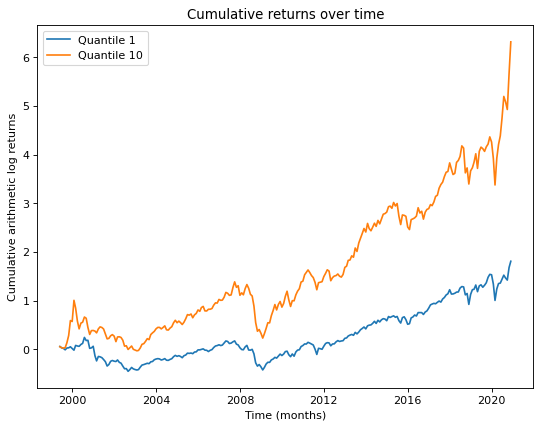

In [175]:
# Calculate cumulative log returns of quantile portfolios
quantile_portfolios_cumprod = np.cumprod(1 + quantile_portfolios, axis=0) - 1

# Add Python datetime to the dataframe (new column called "Date")
quantile_portfolios_cumprod['Date'] = pd.to_datetime(quantile_portfolios_cumprod.index, format="%Y%m")

# Plot the cumulative fama-french factors over time
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(quantile_portfolios_cumprod['Date'], quantile_portfolios_cumprod.iloc[:,np.r_[1,9]])
plt.title('Cumulative returns over time')
plt.legend(["Quantile {}".format(q) for q in [1,10]])
plt.xlabel('Time (months)')
plt.ylabel('Cumulative arithmetic log returns')
plt.show()

In [176]:
quantile_portfolios_cumprod

,0,1,2,3,4,5,6,7,8,9,Holding period,Date
199212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1992-12-01
199301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,1993-01-01
199302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000e+00,1993-02-01
199303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.000000e+00,1993-03-01
199304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.500000e+01,1993-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...
202008,1.59454,1.52551,2.25013,2.61115,2.39862,3.1172,2.83779,3.82723,4.05562,5.19754,8.749003e+99,2020-08-01
202009,1.50744,1.46658,2.1811,2.50752,2.30475,2.98239,2.72486,3.6918,3.88571,5.08577,1.749801e+100,2020-09-01
202010,1.50407,1.42446,2.13571,2.49615,2.27036,2.91796,2.65603,3.59858,3.76566,4.92903,3.499601e+100,2020-10-01
202011,1.76434,1.68374,2.50848,2.93786,2.67313,3.38161,3.04827,4.13426,4.29295,5.66994,6.999202e+100,2020-11-01


In [ ]:
# Scatter plot and fitted line between two columns
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

x = df_column1_x
y = df_column2_y
plt.scatter(x.values,y.values)
plt.xlabel(x.name)
plt.ylabel(y.name)

x, y = x.values.reshape(-1,1), y.values.reshape(-1,1)
plt.plot(x, LinearRegression().fit(x, y).predict(x), color = 'red')
plt.show()

### This is for creating a lag of 1 month. Run only if necessary

In [31]:
# # Settings
# lag = 12                         # lag of 1 month
# lookforward = 1                 # Evaluation period is 12 (or 3 or 1) months (one year into the future). 
# rebalance = lookforward + lag   # Rebalancing frequency is NOT equal to lookforward period (every 13 months)
# number_quantiles = 10           # Number of quantile portfolios to create. For this example we will create DECILES.
# #rank_variable = '12M return'   # Characteristic on which funds will be sorted into quantiles
# rank_variable = 'mgmt_fee'      # Characteristic on which funds will be sorted into quantiles

# # Get the string representation of the months starting in December 1992 (first rebalancing moment)
# dates = famafrench.index[famafrench.index >= 199212].unique()

# # Initialize results
# quantile_portfolios = pd.DataFrame(data=None, index=dates, columns=range(0, number_quantiles))
# quantile_portfolios_other_variable_pd = pd.DataFrame(data=None, index=dates, columns=range(0, number_quantiles))

# # Loop over the dates
# for period in trange(0, len(dates), rebalance):
    
#     #print(f'the period is {period}')

#     # Get the current date
#     current_date = dates[period]
#     #print(f'the current date is {current_date}')
    
#     # Get all dates of the next year (lookforward window)
#     lookforward_period = dates[period+1:period+lookforward+1]
#     #print(f'the lookforward period is {lookforward_period}')
    
#     # Assign a cumulative number for each period in the future (so we can group by this later)
#     quantile_portfolios_index = quantile_portfolios.index.isin(lookforward_period)
#     quantile_portfolios.loc[quantile_portfolios_index, 'Holding period'] = range(1, len(lookforward_period)+1)
    
#     # Get all funds at this period in time (in this iteration)
#     funds_this_period_index = data.index.get_level_values('YYYYMM') == current_date
#     funds_this_period = data.loc[funds_this_period_index]
    
#     # If less than 100 funds in total, ignore the code below
#     if funds_this_period[rank_variable].count() < 100:
#         continue
    
#     # Sort the funds into quantiles (using pandas 'qcut' function)
#     quantiles_index = pd.qcut(funds_this_period[rank_variable], number_quantiles, labels=range(0, number_quantiles))
    
#     # Loop over each quantile
#     for q in range(0, number_quantiles):
        
#         # Get the fund identifiers that are part of this quantile
#         funds_in_quantile = quantiles_index.index.get_level_values('crsp_fundno')[quantiles_index == q]
        
#         # Get the forward-looking returns of the funds that belong to this quantile
#         fund_returns_index = np.logical_and(
#             data.index.get_level_values('YYYYMM').isin(lookforward_period),
#             data.index.get_level_values('crsp_fundno').isin(funds_in_quantile)
#         )
#         fund_returns = data.loc[fund_returns_index, 'mret']
#         fund_other_rank_variable = data.loc[fund_returns_index, rank_variable]
        
#         # Put the dates as columns (instead of having a multi-column index, make separate columns for each date)
#         fund_returns = fund_returns.unstack(level='YYYYMM')
#         fund_other_rank_variable = fund_other_rank_variable.unstack(level='YYYYMM')
        
#         # Define the weighting scheme.
#         # For now, we will created equally-weighted quantile portfolios.
#         # We assume that if a mutual fund closes, we can reinvest our redeemed money in the remaining funds.
#         # These weights are the basis for the other rank variable 
#         fund_weights = fund_returns.notna().astype(int)
#         fund_weights = fund_weights.div(fund_weights.sum(axis=0), axis=1)
        
#         # Multiply returns with weights to get the return of the quantile portfolio and also for the other variable
#         quantile_portfolio_return = (fund_returns * fund_weights).sum(axis=0, skipna=True)
#         quantile_portfolios_other_variable = (fund_other_rank_variable * fund_weights).sum(axis=0, skipna=True)
        
#         # Save the future returns for this quantile in the 'quantile_portfolios' dataframe
#         quantile_portfolios_index = quantile_portfolios.index.isin(lookforward_period)
#         quantile_portfolios.loc[quantile_portfolios_index, q] = quantile_portfolio_return
#         quantile_portfolios_other_variable_index = quantile_portfolios_other_variable_pd.index.isin(lookforward_period)
#         quantile_portfolios_other_variable_pd.loc[quantile_portfolios_other_variable_index, q] = quantile_portfolios_other_variable        
        
# print('Quantile portfolios are created.')


Quantile portfolios are created.


### Plot cumulative returns of quantile portfolios

In [8]:
# # Calculate cumulative log returns of quantile portfolios
# quantile_portfolios_cumprod = np.cumprod(1 + quantile_portfolios, axis=0) - 1

# # Add Python datetime to the dataframe (new column called "Date")
# quantile_portfolios_cumprod['Date'] = pd.to_datetime(quantile_portfolios_cumprod.index, format="%Y%m")

# # Plot the cumulative fama-french factors over time
# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(quantile_portfolios_cumprod['Date'], quantile_portfolios_cumprod[range(0,number_quantiles)])
# plt.title('Cumulative returns over time')
# plt.legend(["Quantile {}".format(q) for q in range(1,number_quantiles+1)])
# plt.xlabel('Time (months)')
# plt.ylabel('Cumulative arithmetic returns')
# plt.show()

### Plot holding-period return for each quantile
_Edit: this plot now works for any holding period_

In [9]:
# # Get the string representation of the months starting in December 1992 (first rebalancing moment)
# dates = famafrench.index[famafrench.index >= 199212].unique()

# # Because portfolios are rebalanced every December, we can simply keep track of the return in each month
# portfolio_returns = quantile_portfolios.copy()

# # Calculate the average returns per portfolio, per month
# returns_per_month = portfolio_returns.fillna(0).groupby(['Holding period']).mean()

# # Calculate the holding-period cumulative return
# holding_returns = np.cumprod(1 + returns_per_month, axis=0) - 1

# # Add a column with the average return per holding period
# holding_returns['Average'] = holding_returns.mean(axis=1)

# # For each fund, subtract the average return
# for q in range(0,number_quantiles):
#     holding_returns[q] = holding_returns[q] - holding_returns['Average']
    
# # Plot the cumulative fama-french factors over time
# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(holding_returns.index, holding_returns[range(0, number_quantiles)])
# plt.title('Cumulative returns over holding period')
# plt.legend(["Q{}".format(q) for q in range(1, number_quantiles+1)], loc='lower left')
# plt.xlabel('Holding period (months)')
# plt.ylabel('Cumulative returns in excess of the average')
# plt.show()

## GRS test 

In [10]:
def GRS_test(factor_matrix, return_matrix):
    # factor_matrix are the values of the factors excluding empty rows in a matrix (T x K)
    # return_matrix are the values of the returns exluding empty rows in a matrix (T x N)
    # N quantiles (assets), K factors, and T time points
    # For example:
    # factor_matrix = portfolios.dropna()[['Mkt-RF', 'SMB', 'HML', 'WML', 'RMW', 'CMA']].values
    # return_matrix = portfolios.dropna().iloc[:,0:10].values
   
    # Initialize the variables
    N = return_matrix.shape[1]
    T = return_matrix.shape[0]
    K = factor_matrix.shape[1]
    e_matrix = np.zeros((T,N))
    b_matrix = np.zeros((N, K+1))
    se_matrix = np.zeros((N, K+1))
    R2_matrix = np.zeros((N, 1))
    t_matrix = np.zeros((N, K+1))
    p_matrix = np.zeros((N, K+1))
    one = np.ones((T,1))
    dat = np.c_[np.ones((T,1)),factor_matrix]
    
    # Loop through each quantile
    for i in range(0, 10):
        x = factor_matrix
        y = return_matrix[:,i] 
        model = LinearRegression().fit(x, y)
        b = np.append(np.array(model.intercept_), model.coef_)
        e = y - np.matmul(dat, b)
        b_matrix[i,:] = b
        e_matrix[:,i] = e
        s2 = sum(e**2)/(T - K - 1)
        cov_matrix = s2 * inv(np.matmul(dat.T, dat))
    
    # Fill in the paramters for the GRS test
    sigma = (np.matmul(e_matrix.T, e_matrix))/(T - K - 1)
    alpha = b_matrix[:,0]
    factor_mean = np.tile(factor_matrix.mean(axis=0), (T, 1))
    omega = np.matmul(factor_matrix.T - factor_mean.T, factor_matrix - factor_mean)/(T - 1)
    tem1 = np.matmul(np.matmul(alpha.T, inv(sigma)),alpha)
    tem2 = 1 + np.matmul(np.matmul((factor_mean[1]), inv(omega)),(factor_mean[0].T))
    tem3 = T/N
    tem4 = (T - N - K)/(T - K - 1)
    F = tem3 * tem4 * (tem1/tem2)
    p_value = 1-f.cdf(F, N, T - N - K)
    
    return(F,p_value)

### Quantile portfolio statistics - Multi Factor

In [11]:
# # To do: make a function of all the models
# number_model = input('What kind of model do you want to choose: \n(1) Multi-Factor \n(2) Fama-French 5-factor \n(3) \
# Carhart 4-factor \n(4) Fama-French 3-factor \n(5) CAPM \nPlease enter the number:\n')
# factor_model_dict = {1: 'Multi-Factor', 2: 'Fama-French 5-factor', 3: 'Carhart 4-factor', \
#                      4:'Fama-French 3-factor', 5:'CAPM'} 

In [125]:
# Multi-factor
factor_model = 'Multi-Factor' 

# Specify portfolios to analyze
portfolios = quantile_portfolios

# Load Fama-French factors
ff = famafrench[famafrench.index.isin(portfolios.index)]

# Merge together
portfolios = portfolios.merge(ff, left_index=True, right_index=True, how='left')

# Initialize results
cols = ["Avg returns", "Avg excess returns", "Volatility", "Sharpe ratio", 
        "Alpha", "Std. error (α)", "t-stat (α)", "p-value (α)", "Beta",
        "SMB", "HML", "WML", "RMW", 'CMA', "R2 adjusted"]
results = pd.DataFrame(data=None, index=portfolios.columns, columns=cols)

# Calculate management fees
#results["Management fees"] = quantile_portfolios_other_variable_pd.mean() * 12

# Calculate average returns
results["Avg returns"] = portfolios.mean() * 12
results.loc[:, "Avg excess returns"] = results.loc[:, "Avg returns"] - results.loc["RF", "Avg returns"]

# Calculate volatility of returns
results["Volatility"] = portfolios.std() * np.sqrt(12)

# Calculate Sharpe ratio
results["Sharpe ratio"] = results["Avg excess returns"] / results["Volatility"]

# Loop over each portfolio
for quantile in range(0, number_quantiles):
    
    # Find index of available data
    index = portfolios[quantile].notna()
    
    # Get x and y variables
    x = portfolios.loc[index, ['Mkt-RF', 'SMB', 'HML', 'WML', 'RMW', 'CMA']].astype(float)
    y = portfolios.loc[index, quantile].astype(float) - portfolios.loc[index, 'RF']
        
    # Note! Need to add intercept myself using this syntax
    x = sm.add_constant(x)
    
    # Fit regression
    model = sm.OLS(y, x).fit()   # Note! y and x are passed to this function in reverse order. It differs per package!
    
    # Save alpha
    results.loc[quantile, "Alpha"] = model.params[0] * 12
    
    # Save standard error of the alpha
    results.loc[quantile, "Std. error (α)"] = model.bse[0]
    
    # Save tstat of the alpha
    results.loc[quantile, "t-stat (α)"] = model.tvalues[0]
    
    # Save p-value of the alpha
    results.loc[quantile, "p-value (α)"] = model.pvalues[0]
    
    # Save beta
    results.loc[quantile, "Beta"] = model.params[1]
    
    # Save SMB
    results.loc[quantile, "SMB"] = model.params[2]
    
    # Save HML
    results.loc[quantile, "HML"] = model.params[3]
    
    # Save RF
    #results.loc[quantile, "RF"] = model.params[4]
    
    # Save WML
    results.loc[quantile, "WML"] = model.params[4]
    
     # Save RMW
    results.loc[quantile, "RMW"] = model.params[5]
    
     # Save CMA
    results.loc[quantile, "CMA"] = model.params[6]
    
    # Save R squared adjusted
    results.loc[quantile, "R2 adjusted"] = model.rsquared_adj
    
    # Save residuals
    vector_resid = model.resid.values[0:251]
    
# Only keep results for relevant factors
results = results.loc[range(0, number_quantiles)]
results.index = ["Q{}".format(q) for q in range(1, number_quantiles+1)]

# Intialize the matrix variables for the GRS test
factor_matrix = portfolios.dropna()[['Mkt-RF', 'SMB', 'HML', 'WML', 'RMW', 'CMA']].values
return_matrix = portfolios.dropna().iloc[:,0:number_quantiles].values

# Print final results
print(f'Based on {factor_model} model, \n\
{lookback} month formation period and {lookforward} month holding period,')
if lookforward != rebalance:
    print(f'with a lag of {rebalance-lookforward} month,')
print(f'the begin date is {quantile_portfolios.index.dropna().min()} and end date is {quantile_portfolios.index.dropna().max()},')
print('the final results are (all numbers annualized):')
display(results.T)
print(f'The GRS test gives us the F-stat of {round(GRS_test(factor_matrix,return_matrix)[0],4)} \n\
and p-value of {round(GRS_test(factor_matrix,return_matrix)[1],4)}.')

Based on Multi-Factor model, 
3 month formation period and 1 month holding period,
the begin date is 201912 and end date is 202012,
the final results are (all numbers annualized):


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
Avg returns,0.0958592,0.130556,0.136232,0.157182,0.193554,0.193454,0.186458,0.256191,0.259459,0.345893
Avg excess returns,0.090413,0.12511,0.130786,0.151736,0.188108,0.188008,0.181012,0.250744,0.254013,0.340447
Volatility,0.281181,0.251308,0.26563,0.272838,0.271693,0.251287,0.253114,0.252151,0.254685,0.263572
Sharpe ratio,0.321547,0.497837,0.49236,0.556139,0.692355,0.74818,0.715139,0.99442,0.997362,1.29166
Alpha,-0.125889,-0.160284,-0.0885683,-0.00901582,0.00540412,0.0102486,0.000261422,0.0773889,0.0094902,-0.0389132
Std. error (α),0.012537,0.00547576,0.00464523,0.00653026,0.00465258,0.00421402,0.00614198,0.00681556,0.00778608,0.0100771
t-stat (α),-0.836781,-2.4393,-1.58888,-0.115052,0.0967943,0.202669,0.00354693,0.946229,0.101572,-0.321797
p-value (α),0.440863,0.0587045,0.172956,0.912882,0.92665,0.847382,0.997307,0.387481,0.923044,0.760625
Beta,0.951383,0.924346,0.987678,0.934068,0.942633,0.898041,0.924801,0.892024,0.886133,0.932642
SMB,-0.15226,0.224773,-0.0809447,-0.158989,-0.0650013,-0.0887901,-0.0465583,-0.0182106,0.185183,0.905649


The GRS test gives us the F-stat of -1606327526016735.0 
and p-value of nan.


### Function to create scatterplot between two columns

In [64]:
def scatterplot(df_column1_x, df_column2_y):
    # Scatter plot and fitted line between two columns
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    x = df_column1_x
    y = df_column2_y
    plt.scatter(x.values,y.values)
    plt.xlabel(x.name)
    plt.ylabel(y.name)

    x, y = x.values.reshape(-1,1), y.values.reshape(-1,1)
    plt.plot(x, LinearRegression().fit(x, y).predict(x), color = 'red')
    plt.show()

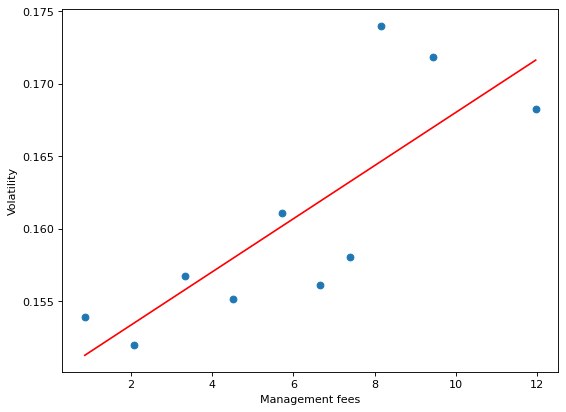

In [67]:
# Scatter plot and fitted line between management fees and avg excess returns
scatterplot(results['Management fees'],results['Volatility'] )

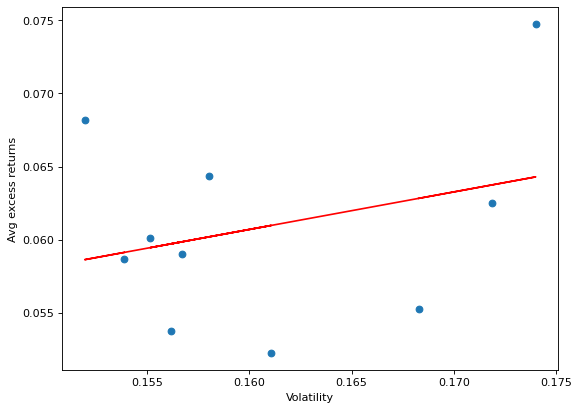

In [66]:
scatterplot(results['Volatility'],results['Avg excess returns'] )

### Quantile portfolio statistics - Fama French 5-factor

In [16]:
# Fama French 5 factor
factor_model = 'Fama-French 5-factor'

# Specify portfolios to analyze
portfolios = quantile_portfolios

# Load Fama-French factors
ff = famafrench[famafrench.index.isin(portfolios.index)]

# Merge together
portfolios = portfolios.merge(ff, left_index=True, right_index=True, how='left')

# Initialize results
cols = ["Avg returns", "Avg excess returns", "Volatility", "Sharpe ratio", 
        "Alpha", "Std. error (α)", "t-stat (α)", "p-value (α)", "Beta",
        "SMB", "HML", "RMW", 'CMA', "R2 adjusted"]
results = pd.DataFrame(data=None, index=portfolios.columns, columns=cols)

# Calculate average returns
results["Avg returns"] = portfolios.mean() * 12
results.loc[:, "Avg excess returns"] = results.loc[:, "Avg returns"] - results.loc["RF", "Avg returns"]

# Calculate volatility of returns
results["Volatility"] = portfolios.std() * np.sqrt(12)

# Calculate Sharpe ratio
results["Sharpe ratio"] = results["Avg excess returns"] / results["Volatility"]

# Initialize matrix of model residuals and factor returns
matrix_res = []
matrix_y = []

# Loop over each portfolio
for quantile in range(0, number_quantiles):
    
    # Find index of available data
    index = portfolios[quantile].notna()
    
    # Get x and y variables
    x = portfolios.loc[index, ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].astype(float)
    y = portfolios.loc[index, quantile].astype(float) - portfolios.loc[index, 'RF']
    matrix_y.append(y.values)
    matrix_y_t = np.transpose(np.array(matrix_y))
    
    # Note! Need to add intercept myself using this syntax
    x = sm.add_constant(x)
    
    # Fit regression
    model = sm.OLS(y, x).fit()   # Note! y and x are passed to this function in reverse order. It differs per package!
    
    # Save alpha
    results.loc[quantile, "Alpha"] = model.params[0] * 12
    
    # Save standard error of the alpha
    results.loc[quantile, "Std. error (α)"] = model.bse[0]
    
    # Save tstat of the alpha
    results.loc[quantile, "t-stat (α)"] = model.tvalues[0]
    
    # Save p-value of the alpha
    results.loc[quantile, "p-value (α)"] = model.pvalues[0]
    
    # Save beta
    results.loc[quantile, "Beta"] = model.params[1]
    
    # Save SMB
    results.loc[quantile, "SMB"] = model.params[2]
    
    # Save HML
    results.loc[quantile, "HML"] = model.params[3]
    
    # Save RF
    #results.loc[quantile, "RF"] = model.params[4]
    
     # Save RMW
    results.loc[quantile, "RMW"] = model.params[4]
    
     # Save CMA
    results.loc[quantile, "CMA"] = model.params[5]
    
    # Save R squared adjusted
    results.loc[quantile, "R2 adjusted"] = model.rsquared_adj
    
    # Save residuals
    matrix_res.append(model.resid.values)
    matrix_res_t = np.transpose(np.array(matrix_res))
    
    
# Only keep results for relevant factors
results = results.loc[range(0, number_quantiles)]
results.index = ["Q{}".format(q) for q in range(1, number_quantiles+1)]

# Intialize the matrix variables for the GRS test
factor_matrix = portfolios.dropna()[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].values
return_matrix = portfolios.dropna().iloc[:,0:number_quantiles].values

# Print final results
print(f'Based on {factor_model} model, \n\
{lookback} month formation period and {lookforward} month holding period,')
if lookforward != rebalance:
    print(f'with a lag of {rebalance-lookforward} month,')
print('the final results are (all numbers annualized):')
display(results.T)
print(f'The GRS test gives us the F-stat of {round(GRS_test(factor_matrix,return_matrix)[0],4)} \n\
and p-value of {round(GRS_test(factor_matrix,return_matrix)[1],4)}.')

Based on Fama-French 5-factor model, 
3 month formation period and 12 month holding period,
the final results are (all numbers annualized):


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
Avg returns,0.0655097,0.0725498,0.0797456,0.0784927,0.0713252,0.0806013,0.0820089,0.0659572,0.0738441,0.058134
Avg excess returns,0.0424533,0.0494935,0.0566892,0.0554363,0.0482688,0.0575449,0.0589525,0.0429008,0.0507878,0.0350776
Volatility,0.184804,0.161696,0.158856,0.15775,0.15338,0.156082,0.156503,0.159757,0.173299,0.193865
Sharpe ratio,0.22972,0.30609,0.356859,0.351418,0.314701,0.368683,0.376686,0.268538,0.293064,0.180939
Alpha,0.000465339,-0.00633854,0.000795025,-0.00406989,-0.0064164,0.0020287,0.000226436,-0.0110395,-0.0025865,-0.0167875
Std. error (α),0.00179806,0.00101265,0.000717019,0.000483338,0.000356393,0.000296153,0.000501778,0.000593288,0.00101769,0.001534
t-stat (α),0.0215667,-0.521616,0.0923992,-0.701698,-1.50031,0.570848,0.0376056,-1.55061,-0.211795,-0.911964
p-value (α),0.982811,0.602407,0.926456,0.483531,0.134821,0.568624,0.970033,0.122286,0.832443,0.362681
Beta,0.957263,0.973505,0.986625,0.994102,0.968201,0.978123,0.975467,0.95316,0.948607,0.914752
SMB,-0.0599036,-0.0226174,-0.0179129,0.00589702,-0.00246791,0.000635024,0.0560606,0.103474,0.206274,0.321996


The GRS test gives us the t-stat of 2.94 
and p-value of 0.0017.


### Quantile portfolio statistics - Carhart 4-factor

In [ ]:
# Carhart
factor_model = 'Carhart 4-factor'

# Specify portfolios to analyze
portfolios = quantile_portfolios

# Load Fama-French factors
ff = famafrench[famafrench.index.isin(portfolios.index)]

# Merge together
portfolios = portfolios.merge(ff, left_index=True, right_index=True, how='left')

# Initialize results
cols = ["Avg returns", "Avg excess returns", "Volatility", "Sharpe ratio", 
        "Alpha", "Std. error (α)", "t-stat (α)", "p-value (α)", "Beta",
        "SMB", "HML", "WML", "R2 adjusted"]
results = pd.DataFrame(data=None, index=portfolios.columns, columns=cols)

# Calculate average returns
results["Avg returns"] = portfolios.mean() * 12
results.loc[:, "Avg excess returns"] = results.loc[:, "Avg returns"] - results.loc["RF", "Avg returns"]

# Calculate volatility of returns
results["Volatility"] = portfolios.std() * np.sqrt(12)

# Calculate Sharpe ratio
results["Sharpe ratio"] = results["Avg excess returns"] / results["Volatility"]

# Initialize matrix of model residuals and factor returns
matrix_res = []
matrix_y = []

# Loop over each portfolio
for quantile in range(0, number_quantiles):
    
    # Find index of available data
    index = portfolios[quantile].notna()
    
    # Get x and y variables
    x = portfolios.loc[index, ['Mkt-RF', 'SMB', 'HML', 'WML']].astype(float)
    y = portfolios.loc[index, quantile].astype(float) - portfolios.loc[index, 'RF']
    matrix_y.append(y.values)
    matrix_y_t = np.transpose(np.array(matrix_y))
    
    # Note! Need to add intercept myself using this syntax
    x = sm.add_constant(x)
    
    # Fit regression
    model = sm.OLS(y, x).fit()   # Note! y and x are passed to this function in reverse order. It differs per package!
    
    # Save alpha
    results.loc[quantile, "Alpha"] = model.params[0] * 12
    
    # Save standard error of the alpha
    results.loc[quantile, "Std. error (α)"] = model.bse[0]
    
    # Save tstat of the alpha
    results.loc[quantile, "t-stat (α)"] = model.tvalues[0]
    
    # Save p-value of the alpha
    results.loc[quantile, "p-value (α)"] = model.pvalues[0]
    
    # Save beta
    results.loc[quantile, "Beta"] = model.params[1]
    
    # Save SMB
    results.loc[quantile, "SMB"] = model.params[2]
    
    # Save HML
    results.loc[quantile, "HML"] = model.params[3]
    
    # Save RF
    #results.loc[quantile, "RF"] = model.params[4]
    
    # Save RML
    results.loc[quantile, "WML"] = model.params[4]
    
    # Save R squared adjusted
    results.loc[quantile, "R2 adjusted"] = model.rsquared_adj
    
    # Save residuals
    matrix_res.append(model.resid.values)
    matrix_res_t = np.transpose(np.array(matrix_res))
    
    
# Only keep results for relevant factors
results = results.loc[range(0, number_quantiles)]
results.index = ["Q{}".format(q) for q in range(1, number_quantiles+1)]

# Intialize the matrix variables for the GRS test
factor_matrix = portfolios.dropna()[['Mkt-RF', 'SMB', 'HML', 'WML']].values
return_matrix = portfolios.dropna().iloc[:,0:number_quantiles].values

# Print final results
print(f'Based on {factor_model} model, \n\
{lookback} month formation period and {lookforward} month holding period,')
if lookforward != rebalance:
    print(f'with a lag of {rebalance-lookforward} month,')
print('the final results are (all numbers annualized):')
display(results.T)
print(f'The GRS test gives us the F-stat of {round(GRS_test(factor_matrix,return_matrix)[0],4)} \n\
and p-value of {round(GRS_test(factor_matrix,return_matrix)[1],4)}.')

### Quantile portfolio statistics - Fama French 3-factor

In [ ]:
# Fama French
factor_model = 'Fama-French 3-factor'

# Specify portfolios to analyze
portfolios = quantile_portfolios

# Load Fama-French factors
ff = famafrench[famafrench.index.isin(portfolios.index)]

# Merge together
portfolios = portfolios.merge(ff, left_index=True, right_index=True, how='left')

# Initialize results
cols = ["Avg returns", "Avg excess returns", "Volatility", "Sharpe ratio", 
        "Alpha", "Std. error (α)", "t-stat (α)", "p-value (α)", "Beta",
        "SMB", "HML"]#, "RF", "WML", "R2 adjusted"]
results = pd.DataFrame(data=None, index=portfolios.columns, columns=cols)

# Calculate average returns
results["Avg returns"] = portfolios.mean() * 12
results.loc[:, "Avg excess returns"] = results.loc[:, "Avg returns"] - results.loc["RF", "Avg returns"]

# Calculate volatility of returns
results["Volatility"] = portfolios.std() * np.sqrt(12)

# Calculate Sharpe ratio
results["Sharpe ratio"] = results["Avg excess returns"] / results["Volatility"]

# Initialize matrix of model residuals and factor returns
matrix_res = []
matrix_y = []

# Loop over each portfolio
for quantile in range(0, number_quantiles):
    
    # Find index of available data
    index = portfolios[quantile].notna()
    
    # Get x and y variables
    x = portfolios.loc[index, ['Mkt-RF', 'SMB', 'HML']].astype(float)
    y = portfolios.loc[index, quantile].astype(float) - portfolios.loc[index, 'RF']
    matrix_y.append(y.values)
    matrix_y_t = np.transpose(np.array(matrix_y))
    
    # Note! Need to add intercept myself using this syntax
    x = sm.add_constant(x)
    
    # Fit regression
    model = sm.OLS(y, x).fit()   # Note! y and x are passed to this function in reverse order. It differs per package!
    
    # Save alpha
    results.loc[quantile, "Alpha"] = model.params[0] * 12
    
    # Save standard error of the alpha
    results.loc[quantile, "Std. error (α)"] = model.bse[0]
    
    # Save tstat of the alpha
    results.loc[quantile, "t-stat (α)"] = model.tvalues[0]
    
    # Save p-value of the alpha
    results.loc[quantile, "p-value (α)"] = model.pvalues[0]
    
    # Save beta
    results.loc[quantile, "Beta"] = model.params[1]
    
    # Save SMB
    results.loc[quantile, "SMB"] = model.params[2]
    
    # Save HML
    results.loc[quantile, "HML"] = model.params[3]
    
    # Save RF
    #results.loc[quantile, "RF"] = model.params[4]
    
    # Save RML
    #results.loc[quantile, "WML"] = model.params[5]
    
    # Save R squared adjusted
    results.loc[quantile, "R2 adjusted"] = model.rsquared_adj
    
    # Save residuals
    matrix_res.append(model.resid.values)
    matrix_res_t = np.transpose(np.array(matrix_res))
    
    
# Only keep results for relevant factors
results = results.loc[range(0, number_quantiles)]
results.index = ["Q{}".format(q) for q in range(1, number_quantiles+1)]

# Intialize the matrix variables for the GRS test
factor_matrix = portfolios.dropna()[['Mkt-RF', 'SMB', 'HML']].values
return_matrix = portfolios.dropna().iloc[:,0:number_quantiles].values

# Print final results
print(f'Based on {factor_model} model, \n\
{lookback} month formation period and {lookforward} month holding period,')
if lookforward != rebalance:
    print(f'with a lag of {rebalance-lookforward} month,')
print('the final results are (all numbers annualized):')
display(results.T)
print(f'The GRS test gives us the F-stat of {round(GRS_test(factor_matrix,return_matrix)[0],4)} \n\
and p-value of {round(GRS_test(factor_matrix,return_matrix)[1],4)}.')


### Quantile portfolio statistics - CAPM

In [56]:
# CAPM
factor_model = 'CAPM'

# Specify portfolios to analyze
portfolios = quantile_portfolios

# Load Fama-French factors
ff = famafrench[famafrench.index.isin(portfolios.index)]

# Merge together
portfolios = portfolios.merge(ff, left_index=True, right_index=True, how='left')

# Initialize results
cols = ["Avg returns", "Avg excess returns", "Volatility", "Sharpe ratio", 
        "Alpha", "Std. error (α)", "t-stat (α)", "p-value (α)", "Beta"]
        #"SMB", "HML", "RF", "WML", "R2 adjusted"]
results = pd.DataFrame(data=None, index=portfolios.columns, columns=cols)

# Calculate average returns
results["Avg returns"] = portfolios.mean() * 12
results.loc[:, "Avg excess returns"] = results.loc[:, "Avg returns"] - results.loc["RF", "Avg returns"]

# Calculate volatility of returns
results["Volatility"] = portfolios.std() * np.sqrt(12)

# Calculate Sharpe ratio
results["Sharpe ratio"] = results["Avg excess returns"] / results["Volatility"]

# Initialize matrix of model residuals and factor returns
matrix_res = []
matrix_y = []

# Loop over each portfolio
for quantile in range(0, number_quantiles):
    
    # Find index of available data
    index = portfolios[quantile].notna()
    
    # Get x and y variables
    x = portfolios.loc[index, ['Mkt-RF']].astype(float)
    y = portfolios.loc[index, quantile].astype(float) - portfolios.loc[index, 'RF']
    matrix_y.append(y.values)
    matrix_y_t = np.transpose(np.array(matrix_y))
    
    # Note! Need to add intercept myself using this syntax
    x = sm.add_constant(x)
    
    # Fit regression
    model = sm.OLS(y, x).fit()   # Note! y and x are passed to this function in reverse order. It differs per package!
    
    # Save alpha
    results.loc[quantile, "Alpha"] = model.params[0] * 12
    
    # Save standard error of the alpha
    results.loc[quantile, "Std. error (α)"] = model.bse[0]
    
    # Save tstat of the alpha
    results.loc[quantile, "t-stat (α)"] = model.tvalues[0]
    
    # Save p-value of the alpha
    results.loc[quantile, "p-value (α)"] = model.pvalues[0]
    
    # Save beta
    results.loc[quantile, "Beta"] = model.params[1]
    
    # Save SMB
    #results.loc[quantile, "SMB"] = model.params[2]
    
    # Save HML
    #results.loc[quantile, "HML"] = model.params[3]
    
    # Save RF
    #results.loc[quantile, "RF"] = model.params[4]
    
    # Save RML
    #results.loc[quantile, "WML"] = model.params[5]
    
    # Save R squared adjusted
    results.loc[quantile, "R2 adjusted"] = model.rsquared_adj
    
    # Save residuals
    matrix_res.append(model.resid.values)
    matrix_res_t = np.transpose(np.array(matrix_res))
    
    
# Only keep results for relevant factors
results = results.loc[range(0, number_quantiles)]
results.index = ["Q{}".format(q) for q in range(1, number_quantiles+1)]

# Intialize the matrix variables for the GRS test
factor_matrix = portfolios.dropna()[['Mkt-RF']].values
return_matrix = portfolios.dropna().iloc[:,0:number_quantiles].values

# Print final results
print(f'Based on {factor_model} model, \n\
{lookback} month formation period and {lookforward} month holding period,')
if lookforward != rebalance:
    print(f'with a lag of {rebalance-lookforward} month,')
print('the final results are (all numbers annualized):')
display(results.T)
print(f'The GRS test gives us the F-stat of {round(GRS_test(factor_matrix,return_matrix)[0],4)} \n\
and p-value of {round(GRS_test(factor_matrix,return_matrix)[1],4)}.')

Based on CAPM model, 
3 month formation period and 1 month holding period,
the final results are (all numbers annualized):


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
Avg returns,0.0703977,0.0624622,0.0734946,0.0776115,0.07419,0.0820348,0.0783976,0.0897094,0.0921987,0.108728
Avg excess returns,0.0473413,0.0394058,0.0504382,0.0545552,0.0511336,0.0589784,0.0553412,0.066653,0.0691424,0.0856714
Volatility,0.208928,0.168371,0.161434,0.158083,0.156615,0.154746,0.156936,0.157068,0.164093,0.181127
Sharpe ratio,0.226592,0.234042,0.312438,0.345106,0.326492,0.381129,0.352635,0.424359,0.421362,0.47299
Alpha,-0.024938,-0.02598,-0.0136335,-0.00869803,-0.0119388,-0.00294868,-0.00756887,0.00509428,0.00742516,0.0256969
Std. error (α),0.00202304,0.000916404,0.000629954,0.000477875,0.000352259,0.000425666,0.000438273,0.00070694,0.00109206,0.00187173
t-stat (α),-1.02725,-2.36249,-1.80351,-1.51679,-2.82434,-0.577268,-1.43915,0.600509,0.566599,1.14408
p-value (α),0.305269,0.0188982,0.0724797,0.130549,0.00510917,0.564264,0.151326,0.548696,0.571481,0.253653
Beta,1.11666,1.01907,1.00047,0.988881,0.986322,0.970107,0.984024,0.964893,0.967137,0.942466
R2 adjusted,0.713566,0.910099,0.953815,0.972272,0.984663,0.977028,0.976348,0.93847,0.865212,0.674529


The GRS test gives us the F-stat of 1.7293 
and p-value of 0.0747.


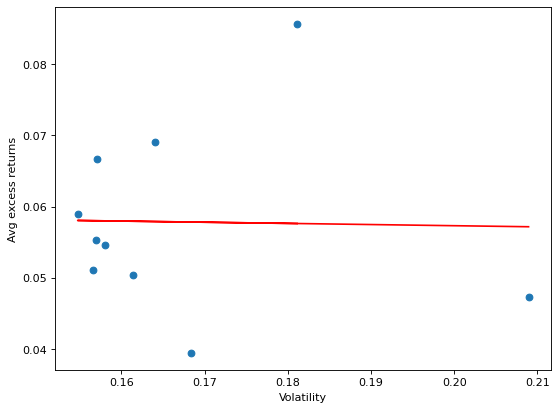

In [57]:
scatterplot(results['Volatility'],results['Avg excess returns'] )

---

# That's it. Now it's up to you to study the code and practice with it!

In [ ]:
"""
  ____        _   _                   _                                                    
 |  _ \ _   _| |_| |__   ___  _ __   (_)___    __ ___      _____  ___  ___  _ __ ___   ___ 
 | |_) | | | | __| '_ \ / _ \| '_ \  | / __|  / _` \ \ /\ / / _ \/ __|/ _ \| '_ ` _ \ / _ \
 |  __/| |_| | |_| | | | (_) | | | | | \__ \ | (_| |\ V  V /  __/\__ \ (_) | | | | | |  __/
 |_|    \__, |\__|_| |_|\___/|_| |_| |_|___/  \__,_| \_/\_/ \___||___/\___/|_| |_| |_|\___|
        |___/                                                                              
        
"""
print('End of notebook.')

---